### Import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession


### Initalize spark session

In [ ]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .config("spark.jars.packages", "com.crealytics:spark-excel_2.12:0.13.5") \
    .getOrCreate()

your 131072x1 screen size is bogus. expect trouble
25/01/14 13:40:03 WARN Utils: Your hostname, Device02072004 resolves to a loopback address: 127.0.1.1; using 172.18.74.112 instead (on interface eth0)
25/01/14 13:40:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/nguylam/myenv/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/nguylam/.ivy2/cache
The jars for the packages stored in: /home/nguylam/.ivy2/jars
com.crealytics#spark-excel_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-3120db3c-a412-413e-a064-42bceef16a2b;1.0
	confs: [default]
	found com.crealytics#spark-excel_2.12;0.13.5 in central
	found org.apache.poi#poi;4.1.2 in central
	found commons-codec#commons-codec;1.13 in central
	found org.apache.commons#commons-collections4;4.4 in central
	found org.apache.commons#commons-math3;3.6.1 in central
	found com.zaxxer#SparseBitSet;1.2 in central
	found org.apache.poi#poi-ooxml;4.1.2 in central
	found org.apache.poi#poi-ooxml-schemas;4.1.2 in central
	found org.apache.xmlbeans#xmlbeans;3.1.0 in central
	found com.github.virtuald#curvesapi;1.06 in central
	found com.norbitltd#spoiwo_2.12;1.7.0 in central
	found org.scala-lang.modules#scala-xml_2.12;1.2.0 in central
	found com.github.pjfanning#excel-streaming-reader;2.3.4 in central

25/01/14 13:40:19 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


### Read train dataset

In [3]:
df_train = spark.read.format("com.crealytics.spark.excel") \
            .option("header", "true") \
            .option("inferSchema", "true") \
            .load("Data_Train.xlsx")
# Displays the content of the DataFrame to stdout
df_train.show()


+-----------------+---------------+--------+-----------+--------------------+--------+------------+--------+-----------+--------------------+-------+
|          Airline|Date_of_Journey|  Source|Destination|               Route|Dep_Time|Arrival_Time|Duration|Total_Stops|     Additional_Info|  Price|
+-----------------+---------------+--------+-----------+--------------------+--------+------------+--------+-----------+--------------------+-------+
|           IndiGo|     24/03/2019|Banglore|  New Delhi|           BLR → DEL|   22:20|01:10 22 Mar|  2h 50m|   non-stop|             No info| 3897.0|
|        Air India|      1/05/2019| Kolkata|   Banglore|CCU → IXR → BBI →...|   05:50|       13:15|  7h 25m|    2 stops|             No info| 7662.0|
|      Jet Airways|      9/06/2019|   Delhi|     Cochin|DEL → LKO → BOM →...|   09:25|04:25 10 Jun|     19h|    2 stops|             No info|13882.0|
|           IndiGo|     12/05/2019| Kolkata|   Banglore|     CCU → NAG → BLR|   18:05|       23:30| 

### Exploratory Data Analysis

In [4]:
df_train.columns

['Airline',
 'Date_of_Journey',
 'Source',
 'Destination',
 'Route',
 'Dep_Time',
 'Arrival_Time',
 'Duration',
 'Total_Stops',
 'Additional_Info',
 'Price']

In [5]:
df_train.describe()

DataFrame[summary: string, Airline: string, Date_of_Journey: string, Source: string, Destination: string, Route: string, Dep_Time: string, Arrival_Time: string, Duration: string, Total_Stops: string, Additional_Info: string, Price: string]

In [7]:
df_train.printSchema()

root
 |-- Airline: string (nullable = true)
 |-- Date_of_Journey: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Destination: string (nullable = true)
 |-- Route: string (nullable = true)
 |-- Dep_Time: string (nullable = true)
 |-- Arrival_Time: string (nullable = true)
 |-- Duration: string (nullable = true)
 |-- Total_Stops: string (nullable = true)
 |-- Additional_Info: string (nullable = true)
 |-- Price: double (nullable = true)



In [8]:
from pyspark.sql.functions import col, isnull, sum
df_train.select([sum(isnull(col(c)).cast("int")).alias(c) for c in df_train.columns]).show()


+-------+---------------+------+-----------+-----+--------+------------+--------+-----------+---------------+-----+
|Airline|Date_of_Journey|Source|Destination|Route|Dep_Time|Arrival_Time|Duration|Total_Stops|Additional_Info|Price|
+-------+---------------+------+-----------+-----+--------+------------+--------+-----------+---------------+-----+
|      0|              0|     0|          0|    1|       0|           0|       0|          1|              0|    0|
+-------+---------------+------+-----------+-----+--------+------------+--------+-----------+---------------+-----+



In [9]:
df_train.filter(
    " OR ".join([f"{c} IS NULL" for c in df_train.columns])
).show()

+---------+---------------+------+-----------+-----+--------+------------+--------+-----------+---------------+------+
|  Airline|Date_of_Journey|Source|Destination|Route|Dep_Time|Arrival_Time|Duration|Total_Stops|Additional_Info| Price|
+---------+---------------+------+-----------+-----+--------+------------+--------+-----------+---------------+------+
|Air India|      6/05/2019| Delhi|     Cochin| NULL|   09:45|09:25 07 May| 23h 40m|       NULL|        No info|7480.0|
+---------+---------------+------+-----------+-----+--------+------------+--------+-----------+---------------+------+



#### Drop NaN values

In [10]:
df_train = df_train.dropna()
df_train.select([sum(isnull(col(c)).cast("int")).alias(c) for c in df_train.columns]).show()

+-------+---------------+------+-----------+-----+--------+------------+--------+-----------+---------------+-----+
|Airline|Date_of_Journey|Source|Destination|Route|Dep_Time|Arrival_Time|Duration|Total_Stops|Additional_Info|Price|
+-------+---------------+------+-----------+-----+--------+------------+--------+-----------+---------------+-----+
|      0|              0|     0|          0|    0|       0|           0|       0|          0|              0|    0|
+-------+---------------+------+-----------+-----+--------+------------+--------+-----------+---------------+-----+



#### Duplicate values

In [11]:
df_train.groupBy(df_train.columns).count().filter("count > 1").show()

+-----------+---------------+--------+-----------+--------------------+--------+------------+--------+-----------+--------------------+-------+-----+
|    Airline|Date_of_Journey|  Source|Destination|               Route|Dep_Time|Arrival_Time|Duration|Total_Stops|     Additional_Info|  Price|count|
+-----------+---------------+--------+-----------+--------------------+--------+------------+--------+-----------+--------------------+-------+-----+
|  Air India|     27/03/2019|   Delhi|     Cochin|DEL → HYD → BOM →...|   21:30|19:15 28 Mar| 21h 45m|    2 stops|             No info| 8665.0|    2|
|  Air India|     03/03/2019|Banglore|  New Delhi|           BLR → DEL|   21:10|       23:55|  2h 45m|   non-stop|             No info| 7591.0|    2|
|Jet Airways|      1/06/2019|   Delhi|     Cochin|DEL → JAI → BOM →...|   09:40|12:35 02 Jun| 26h 55m|    2 stops|In-flight meal no...|10368.0|    2|
|Jet Airways|     18/05/2019|   Delhi|     Cochin|DEL → AMD → BOM →...|   23:05|04:25 20 May| 29h 20

In [12]:
df_train = df_train.dropDuplicates()

In [13]:
print(f"Number of rows: {df_train.count()}")
print(f"Number of columns: {len(df_train.columns)}")


Number of rows: 10462
Number of columns: 11


#### Checking the Additional_info column and having the count of unique types of values.

In [13]:
df_train.groupBy("Additional_info").count().show()

+--------------------+-----+
|     Additional_info|count|
+--------------------+-----+
|In-flight meal no...| 1926|
|No check-in bagga...|  318|
|             No info| 8182|
|      Business class|    4|
|             No Info|    3|
|      1 Long layover|   19|
|      2 Long layover|    1|
|     1 Short layover|    1|
|      Red-eye flight|    1|
|     Change airports|    7|
+--------------------+-----+



In [14]:
# import pyspark.pandas as ps
# import pandas as pd
# # Read the Excel file using pandas
# df_pandas = pd.read_excel('Data_Train.xlsx', index_col=0, header=0)
# df = ps.read(df_pandas)

### Data Visualization of Flight Price Prediction using Machine Learning

In [14]:
df_train.groupBy("Airline").count().show()

+--------------------+-----+
|             Airline|count|
+--------------------+-----+
|           Air India| 1694|
|            SpiceJet|  815|
|               GoAir|  194|
|              Trujet|    1|
|         Jet Airways| 3700|
|Multiple carriers...|   13|
|              IndiGo| 2043|
|            Air Asia|  319|
|             Vistara|  478|
|Jet Airways Business|    6|
|   Multiple carriers| 1196|
|Vistara Premium e...|    3|
+--------------------+-----+



#### Plotting Price vs Airline plot

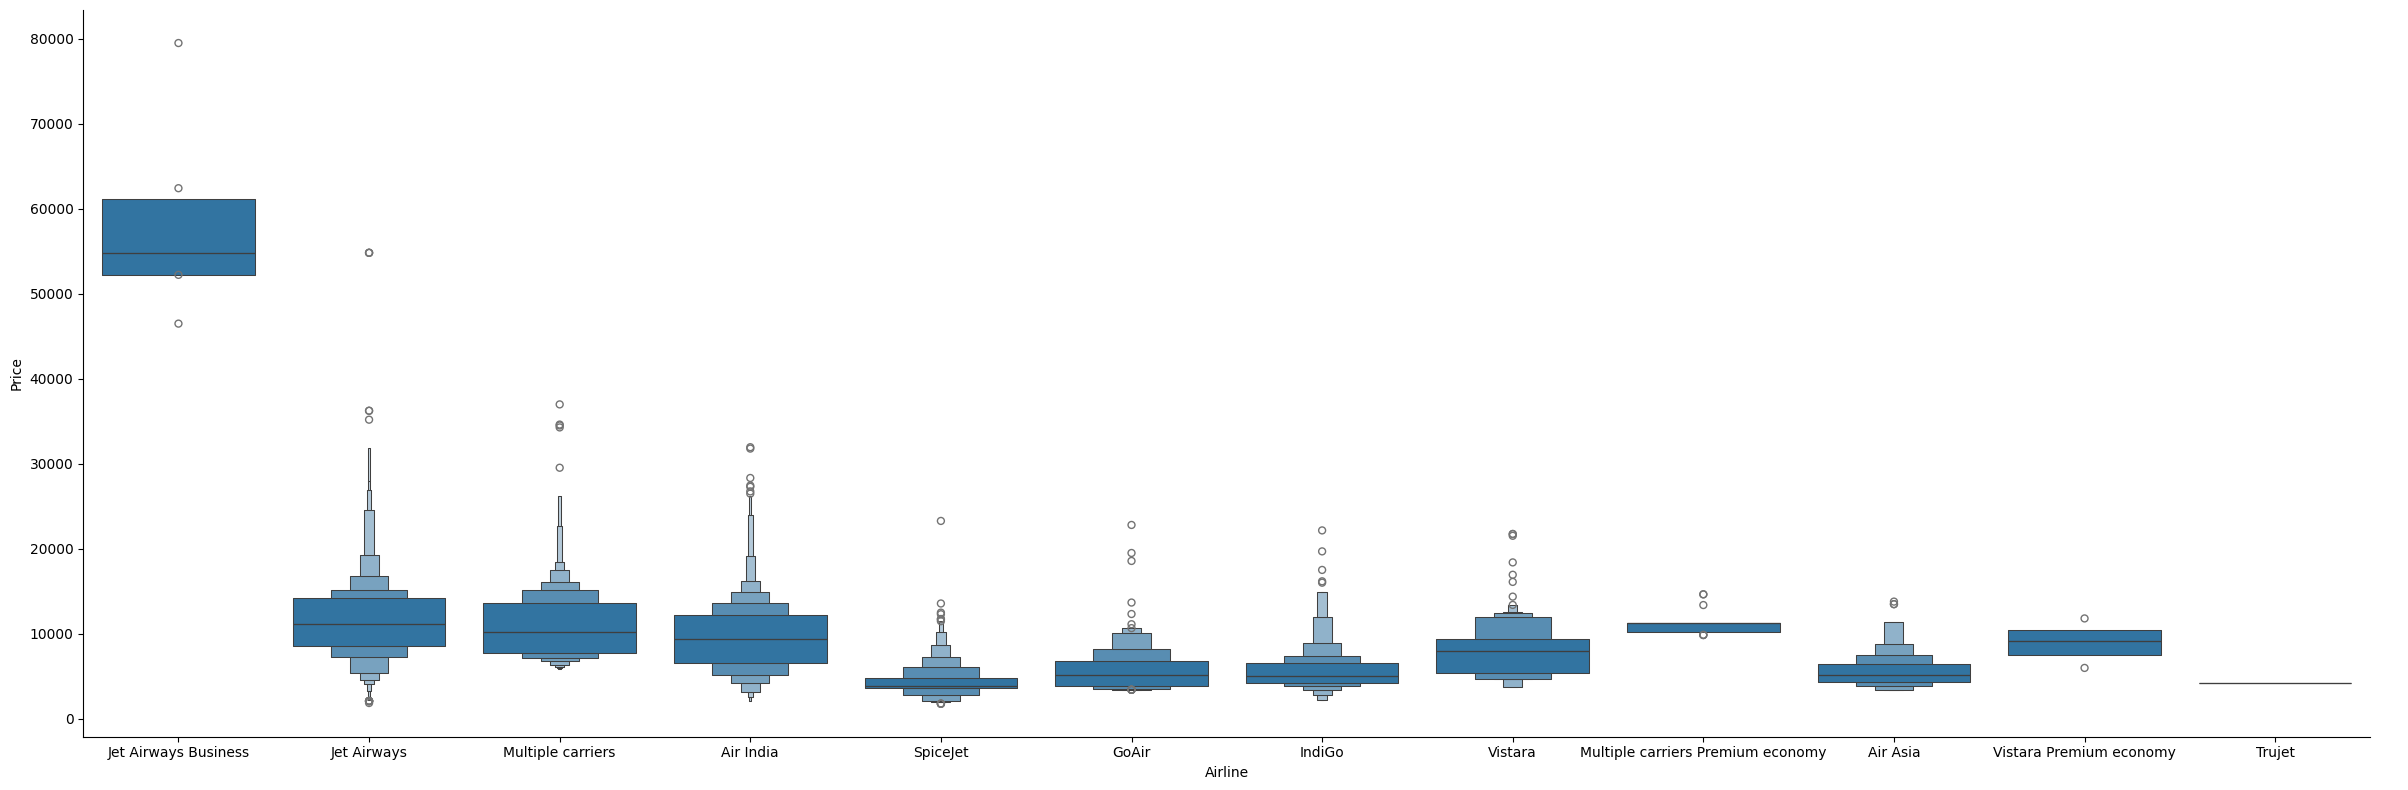

In [15]:
df = df_train.toPandas()
sns.catplot(y = "Price", x = "Airline", data = df.sort_values("Price", ascending = False), kind="boxen", height = 8, aspect = 3)


#### Plotting Violin plot for Price vs Source

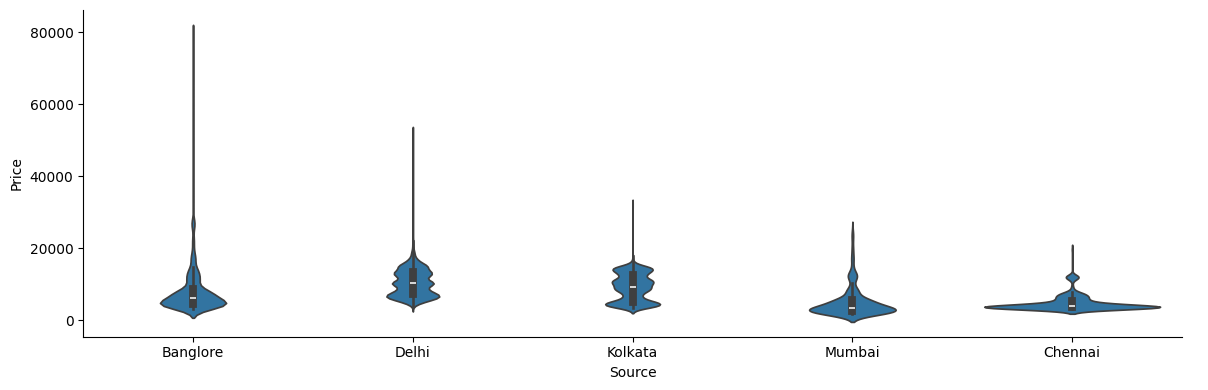

In [16]:
sns.catplot(y = "Price", x = "Source", data = df.sort_values("Price", ascending = False), kind="violin", height = 4, aspect = 3)
plt.show()

#### Plotting Box plot for Price vs Destination

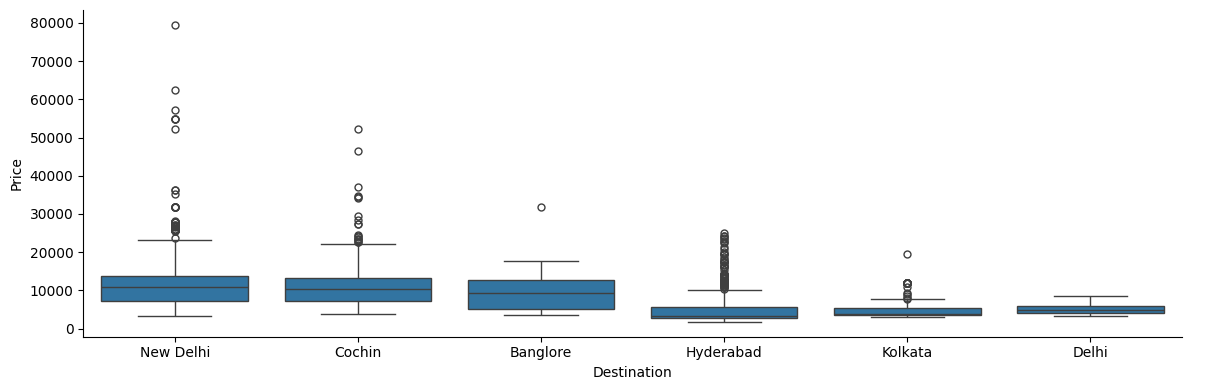

In [17]:
sns.catplot(y = "Price", x = "Destination", data = df.sort_values("Price", ascending = False), kind="box", height = 4, aspect = 3)
plt.show()

### Feature Engineering

In [19]:
# pyspark_df = spark.createDataFrame(df)

In [18]:
df['Duration'] = df['Duration'].str.replace("h", '*60').str.replace(' ','+').str.replace('m','*1').apply(eval)


In [19]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,Jet Airways,06/03/2019,Banglore,New Delhi,BLR → BOM → DEL,07:00,13:15,375,1 stop,No info,19225.0
1,IndiGo,6/03/2019,Mumbai,Hyderabad,BOM → GOI → HYD,15:45,23:00,435,1 stop,No info,7681.0
2,IndiGo,9/05/2019,Banglore,Delhi,BLR → DEL,23:30,02:20 10 May,170,non-stop,No info,3943.0
3,IndiGo,6/06/2019,Kolkata,Banglore,CCU → PNQ → BLR,21:00,02:15 07 Jun,315,1 stop,No info,6711.0
4,IndiGo,18/05/2019,Kolkata,Banglore,CCU → MAA → BLR,17:35,22:15,280,1 stop,No info,5699.0


In [20]:
df["Journey_day"] = df['Date_of_Journey'].str.split('/').str[0].astype(int)
df["Journey_month"] = df['Date_of_Journey'].str.split('/').str[1].astype(int)
df.drop(["Date_of_Journey"], axis = 1, inplace = True)

In [21]:
df["Dep_hour"] = pd.to_datetime(df["Dep_Time"]).dt.hour
df["Dep_min"] = pd.to_datetime(df["Dep_Time"]).dt.minute
df.drop(["Dep_Time"], axis = 1, inplace = True)

/tmp/ipykernel_15895/560082399.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Dep_hour"] = pd.to_datetime(df["Dep_Time"]).dt.hour
/tmp/ipykernel_15895/560082399.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Dep_min"] = pd.to_datetime(df["Dep_Time"]).dt.minute


In [22]:
df["Arrival_hour"] = pd.to_datetime(df.Arrival_Time).dt.hour
df["Arrival_min"] = pd.to_datetime(df.Arrival_Time).dt.minute
df.drop(["Arrival_Time"], axis = 1, inplace = True)

/tmp/ipykernel_15895/3223598577.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Arrival_hour"] = pd.to_datetime(df.Arrival_Time).dt.hour
/tmp/ipykernel_15895/3223598577.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Arrival_min"] = pd.to_datetime(df.Arrival_Time).dt.minute


In [23]:
df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,Jet Airways,Banglore,New Delhi,BLR → BOM → DEL,375,1 stop,No info,19225.0,6,3,7,0,13,15
1,IndiGo,Mumbai,Hyderabad,BOM → GOI → HYD,435,1 stop,No info,7681.0,6,3,15,45,23,0
2,IndiGo,Banglore,Delhi,BLR → DEL,170,non-stop,No info,3943.0,9,5,23,30,2,20
3,IndiGo,Kolkata,Banglore,CCU → PNQ → BLR,315,1 stop,No info,6711.0,6,6,21,0,2,15
4,IndiGo,Kolkata,Banglore,CCU → MAA → BLR,280,1 stop,No info,5699.0,18,5,17,35,22,15


#### Correlation Between all Features

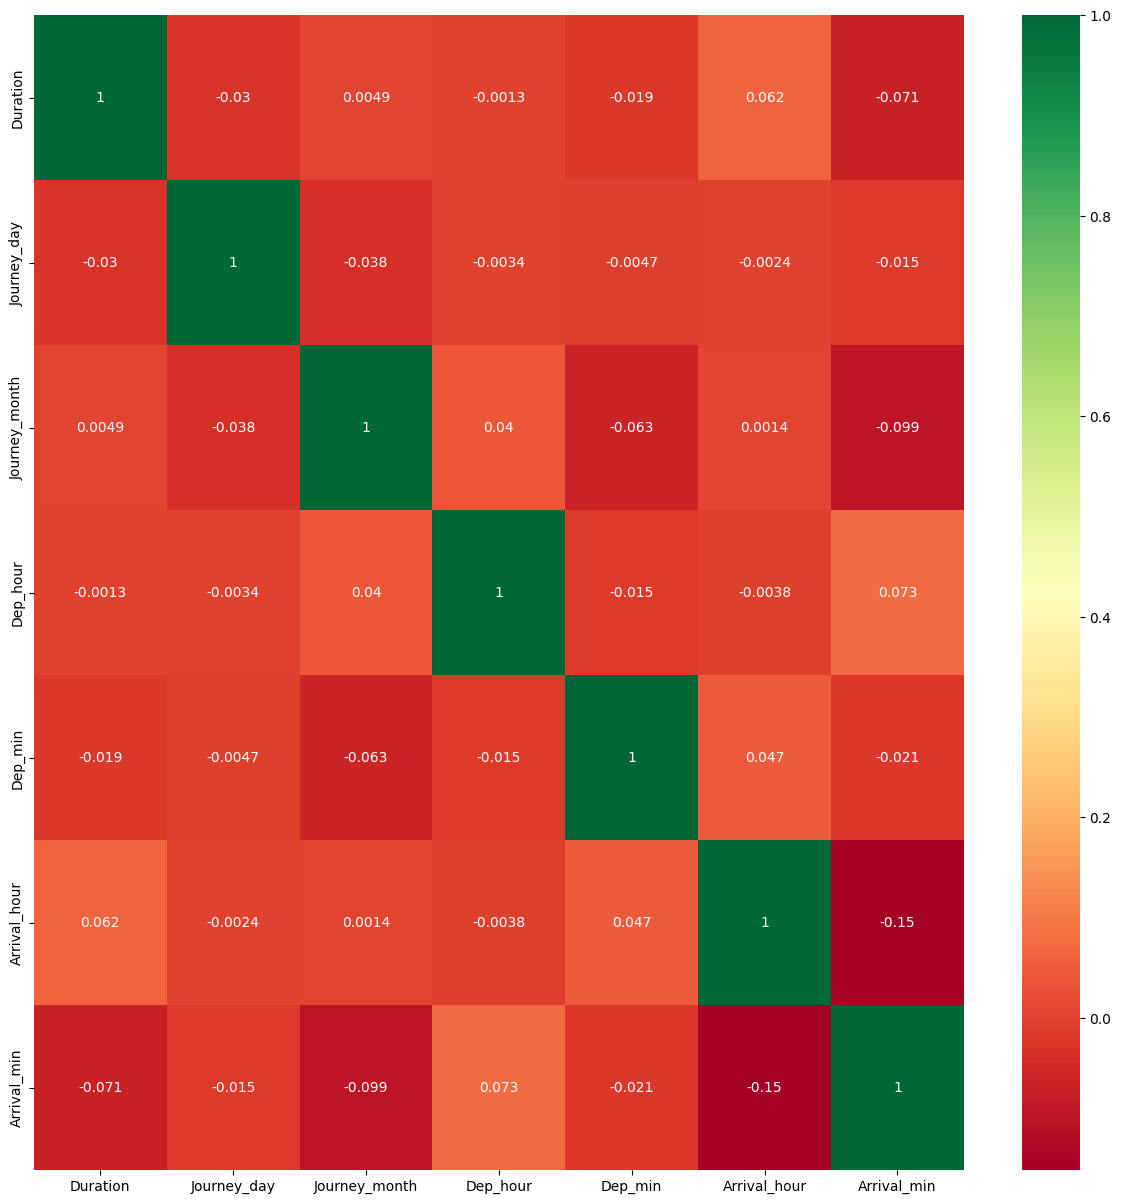

In [24]:
data = df.drop(["Price"], axis=1)
train_numerical_data = data.select_dtypes(include=['int64', 'float','int32'])
train_categorical_data = data.select_dtypes(exclude=['int64', 'float','int32'])

plt.figure(figsize = (15,15))
sns.heatmap(train_numerical_data.corr(), annot = True, cmap = "RdYlGn")
plt.show()

#### Label Encode and Hot Encode for Categorical Columns

In [25]:
train_categorical_data_pyspark = spark.createDataFrame(train_categorical_data)
train_numerical_data_pyspark = spark.createDataFrame(train_numerical_data)
df_pyspark = spark.createDataFrame(df)

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import monotonically_increasing_id

# train_categorical_data_pyspark = spark.createDataFrame(train_categorical_data)
# train_numerical_data_pyspark = spark.createDataFrame(train_numerical_data )

# train_categorical_data_pyspark = train_categorical_data_pyspark.withColumn("id", monotonically_increasing_id())
# train_numerical_data_pyspark = train_numerical_data_pyspark.withColumn("id", monotonically_increasing_id())

# merged_df = train_categorical_data_pyspark.join(train_numerical_data_pyspark, on="id").drop("id")

# merged_df.show()

indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="skip")
    for col in train_categorical_data_pyspark.columns
]

# encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in train_categorical_data_pyspark.columns]

# df_spark = spark.createDataFrame(df)


# assembled_cols = [f"{col}_index" for col in train_categorical_data_pyspark.columns] + train_numerical_data_pyspark.columns

# assembler = VectorAssembler(inputCols=assembled_cols, outputCol="features")



In [27]:
# Tạo Pipeline để áp dụng tất cả các StringIndexer
# pipeline = Pipeline(stages=indexers)
# final_df = pipeline.fit(merged_df).transform(merged_df)
# Fit và transform dữ liệu
# train_categorical_data_pyspark = pipeline.fit(train_categorical_data_pyspark).transform( train_categorical_data_pyspark)
# train_numerical_data_pyspark = spark.createDataFrame(train_numerical_data )
# train_categorical_data_pyspark = train_categorical_data_pyspark.withColumn("id", monotonically_increasing_id())

# train_numerical_data_pyspark = train_numerical_data_pyspark.withColumn("id", monotonically_increasing_id())
# merged_df = train_categorical_data_pyspark.join(train_numerical_data_pyspark, on="id").drop("id")

# train_categorical_data = train_categorical_data.apply(LabelEncoder().fit_transform)
# test_categorical_data = test_categorical_data.apply(LabelEncoder().fit_transform)
# train_categorical_data.head()
# train_numerical_data_pyspark = spark.createDataFrame(train_numerical_data)
feature_columns = [col + "_index" for col in train_categorical_data_pyspark.columns] + [col for col in train_numerical_data_pyspark.columns]

# Assemble features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [28]:
# Define Logistic Regression model
from pyspark.ml.regression import LinearRegression 
lr = LinearRegression(featuresCol="features", labelCol="Price")
# Create pipeline
pipeline = Pipeline(stages=indexers  + [assembler, lr])

In [29]:
# pipeline = Pipeline(stages=)
train_set, test_set = df_pyspark.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_set)
# merged_df.show()

25/01/14 13:59:37 WARN Instrumentation: [168533c0] regParam is zero, which might cause numerical instability and overfitting.
25/01/14 13:59:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/01/14 13:59:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
25/01/14 13:59:40 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


### Read test dataset

In [30]:
df_test = spark.read.format("com.crealytics.spark.excel") \
            .option("header", "true") \
            .option("inferSchema", "true") \
            .load("Test_set.xlsx")

In [32]:
df_test_Pandas = df_test.toPandas()

In [40]:
# df_test_Pandas['Duration'] = df_test_Pandas['Duration'].str.replace("h", '*60').str.replace(' ','+').str.replace('m','*1').apply(eval)
df_test_Pandas["Journey_day"] = df_test_Pandas['Date_of_Journey'].str.split('/').str[0].astype(int)
df_test_Pandas["Journey_month"] = df_test_Pandas['Date_of_Journey'].str.split('/').str[1].astype(int)
df_test_Pandas.drop(["Date_of_Journey"], axis = 1, inplace = True)
df_test_Pandas["Dep_hour"] = pd.to_datetime(df_test_Pandas["Dep_Time"]).dt.hour
df_test_Pandas["Dep_min"] = pd.to_datetime(df_test_Pandas["Dep_Time"]).dt.minute
df_test_Pandas.drop(["Dep_Time"], axis = 1, inplace = True)
df_test_Pandas["Arrival_hour"] = pd.to_datetime(df_test_Pandas.Arrival_Time).dt.hour
df_test_Pandas["Arrival_min"] = pd.to_datetime(df_test_Pandas.Arrival_Time).dt.minute
df_test_Pandas.drop(["Arrival_Time"], axis = 1, inplace = True)
test_categorical_data = df_test_Pandas.select_dtypes(exclude=['int64', 'float','int32','int32'])
test_numerical_data  = df_test_Pandas.select_dtypes(include=['int64', 'float','int32'])

/tmp/ipykernel_15895/577998875.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_test_Pandas["Dep_hour"] = pd.to_datetime(df_test_Pandas["Dep_Time"]).dt.hour
/tmp/ipykernel_15895/577998875.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_test_Pandas["Dep_min"] = pd.to_datetime(df_test_Pandas["Dep_Time"]).dt.minute
/tmp/ipykernel_15895/577998875.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_test_Pandas["Arrival_hour"] = pd.to_datetime(df_test_Pandas.Arrival_Time).dt.hour
/tmp/ipykernel_15895/577998875.py:9: UserWarning: Could not infer format, so each ele

In [41]:
test_categorical_data_pyspark = spark.createDataFrame(test_categorical_data)
test_numerical_data_pyspark = spark.createDataFrame(test_numerical_data)
df_test_pyspark = spark.createDataFrame(df_test_Pandas)


In [42]:
test_categorical_data.head()
test_pred = model.transform(df_test_pyspark)

In [50]:
train_pred = model.transform(df_pyspark)
# test_pred.select("features", "Price", "prediction").show()

In [52]:
train_pred.select("features", "Price", "prediction").show()

+--------------------+-------+------------------+
|            features|  Price|        prediction|
+--------------------+-------+------------------+
|[0.0,2.0,3.0,6.0,...|19225.0| 11261.92495427138|
|[1.0,3.0,4.0,110....| 7681.0|11590.036113707913|
|[1.0,2.0,2.0,1.0,...| 3943.0| 6047.293086333848|
|[1.0,1.0,1.0,44.0...| 6711.0| 9154.927329814956|
|[1.0,1.0,1.0,16.0...| 5699.0| 7807.760070865779|
|[0.0,0.0,0.0,23.0...|13848.0|10705.646109969133|
|(13,[5,6,7,8,9,11...|10262.0|12242.271327562932|
|[1.0,1.0,1.0,3.0,...| 4804.0| 6198.647436930505|
|[2.0,0.0,0.0,22.0...|10441.0|12700.812251614261|
|[4.0,1.0,1.0,3.0,...| 3873.0| 6965.895162033956|
|[2.0,1.0,1.0,5.0,...|10203.0| 9333.946773841506|
|[2.0,1.0,1.0,98.0...| 7662.0|10134.612703649982|
|(13,[0,6,7,8,9,11...|10197.0| 9220.610885427215|
|[4.0,3.0,4.0,4.0,...| 2753.0| 5744.667931990503|
|(13,[0,6,7,8,9,11...| 7934.0| 9987.511688921617|
|[7.0,2.0,2.0,1.0,...| 3898.0| 4233.031800684803|
|[0.0,0.0,0.0,23.0...|13376.0| 12918.87070203286|


In [53]:
from pyspark.ml.evaluation import RegressionEvaluator

# Khởi tạo evaluator cho các chỉ số
evaluator_rmse = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="r2")

# Tính toán các chỉ số
rmse = evaluator_rmse.evaluate(train_pred)
mae = evaluator_mae.evaluate(train_pred)
r2 = evaluator_r2.evaluate(train_pred)

# In kết quả
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")


Root Mean Squared Error (RMSE): 3628.3767476860826
Mean Absolute Error (MAE): 2571.505560447205
R-squared (R²): 0.38312569714646216
